In [1]:
import numpy as np
import matplotlib.pyplot as plt

from jax import jit, vmap, config
import jax.numpy as jnp
import jax.random as jr
import jax.scipy.linalg as jsl

import numpyro
import numpyro.distributions as dist
from numpyro.infer.initialization import init_to_value

import sys
import os
sys.path.append(os.path.abspath('..'))

from PTA import PTA
from ent_likelihood import Likelihood
from samples import Samples

from ent_data_simulation import params_injected

# use double precision
config.update('jax_enable_x64', True)

%load_ext autoreload
%autoreload 2

In [2]:
# make likelihood object from Enterprise data

data_dict = np.load('ent_data_simulation/data/data_dict.npz')

U_s = jnp.array([jnp.linalg.svd(M)[0] for M in data_dict['Ms']])
Gs = jnp.array([U[:, 8:] for U in U_s])
Ntinvs = jnp.array([G @ jnp.linalg.inv(G.T @ N @ G) @ G.T
                    for G, N in zip(Gs, data_dict['Ns'])])

Rs = jnp.array([jnp.eye(data_dict['toas'].shape[1]) - M @ jnp.linalg.inv(M.T @ M) @ M.T
                for M in data_dict['Ms']])

pta_for_parameters = PTA(Np=params_injected.num_psrs,
                         Tspan_yr=15.,
                         Nf=params_injected.num_modes,
                         model_wn=True,
                         model_rn=True,
                         model_gwb=False,
                         model_cw=False,
                         gwb_free_spectral=False,
                         )

l = Likelihood(toas=data_dict['toas'],
               residuals=data_dict['residuals'],
               Ntinvs=Ntinvs,
               Fs=data_dict['Fs'],
               Ntoas=data_dict['toas'].shape[1],
               Np=params_injected.num_psrs,
               Na=params_injected.num_coeff,
               alpha=jnp.zeros((params_injected.num_psrs, params_injected.num_psrs)),
               psr_dists_inj=data_dict['psr_dists'][0],
               psr_dists_stdev=data_dict['psr_dists'][1],
               x_mins=pta_for_parameters.x_mins,
               x_maxs=pta_for_parameters.x_maxs)

In [3]:
# posterior density
@jit
def lnpost(x):
    
    # unpack parameters
    efacs = x[pta_for_parameters.efac_ndxs]
    rn_hypers = x[pta_for_parameters.rn_ndxs]
    a = x[pta_for_parameters.a_ndxs]

    # prior
    lnprior_val = l.uniform_lnprior(x)
    lnprior_val += l.a_lnprior_rn(rn_hypers, a)

    # likelihood
    lnlike_val = l.lnlike(efacs, a)

    return lnprior_val + lnlike_val


vectorized_lnpost = jit(vmap(lnpost))

In [5]:
a_ML = jnp.array([jnp.linalg.pinv(F) @ res for F, res in zip(l.Fs, l.residuals)]).flatten()
x_inj = jnp.concatenate((jnp.ones(l.Np), params_injected.RN_hypers_inj, a_ML))

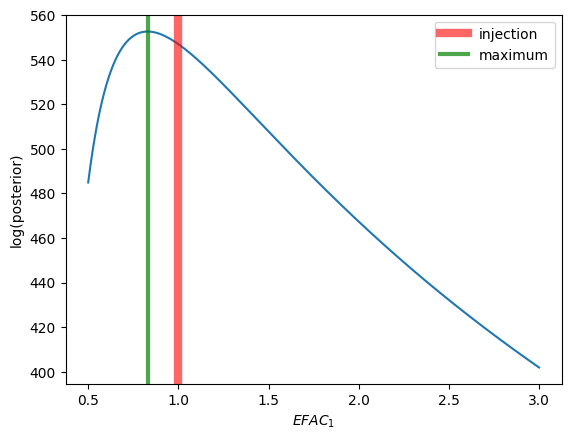

In [12]:
# plot cross-section of posterior
param_ndx = 0
num_evals = 1000
param_vals = jnp.linspace(l.x_mins[param_ndx], l.x_maxs[param_ndx], num_evals)
params = jnp.tile(x_inj, (num_evals, 1))
params = params.at[:, param_ndx].set(param_vals)
lnposts = vectorized_lnpost(params)
plt.plot(param_vals, lnposts)
plt.axvline(x_inj[param_ndx], color='red', label='injection', lw=6, alpha=0.6)
plt.axvline(param_vals[jnp.argmax(lnposts)], color='green', label='maximum', lw=3, alpha=0.7)
plt.legend()
plt.xlabel(pta_for_parameters.x_labels[param_ndx])
plt.ylabel('log(posterior)')
plt.show()

In [8]:
@jit
def transform_a(rn_hypers, a_standard):
    rn_phi = jnp.zeros((l.Na, l.Np, l.Np))
    rn_phi = rn_phi.at[:, jnp.arange(l.Np), jnp.arange(l.Np)].set(l.vectorized_get_rho_diag(rn_hypers.reshape((l.Np, 2))).T)
    phi = rn_phi
    Lc = vmap(lambda x: jsl.cholesky(x, lower=True))(phi)
    a_transformed = vmap(lambda L, x: L @ x)(Lc, a_standard.reshape((l.Np, l.Na)).T).T.flatten()
    return a_transformed

In [24]:
def sampling_model():
    # uniform prior on hyper-parameters
    efacs = numpyro.sample('efacs', dist.Uniform(pta_for_parameters.efac_mins,
                                                         pta_for_parameters.efac_maxs))
    rn_hypers = numpyro.sample('rn_hypers', dist.Uniform(pta_for_parameters.rn_mins,
                                                         pta_for_parameters.rn_maxs))

    # normal prior on Fourier coefficients
    a_standard = numpyro.sample('a_standard', dist.Normal().expand([pta_for_parameters.Na_PTA]))
    a_transformed = transform_a(rn_hypers, a_standard)
    a = numpyro.deterministic('a', a_transformed)

    # likelihood
    numpyro.factor('ln_likelihood', l.lnlike(efacs, a))

In [25]:
# injected parameters in dictionary
# x_inj_dict = {'efacs':pta.efacs_inj, 'rn_hypers':pta.rn_inj, 'gwb_hypers':pta.gwb_inj,
#               'cw':pta.cw_inj, 'psr_phases':pta.psr_phases_inj, 'psr_dists':pta.psr_dists_inj,
#               'a_standard':jnp.zeros(pta.Na_PTA)}
x_inj_dict = {'efacs':jnp.ones(l.Np),
              'rn_hypers': params_injected.RN_hypers_inj,
              'a_standard':jnp.ones(pta_for_parameters.Na_PTA)}

In [26]:
nuts_kernel = numpyro.infer.NUTS(sampling_model,
                                 # init_strategy=init_to_value(values=x_inj_dict),
                                 dense_mass=True,
                                 )
mcmc = numpyro.infer.MCMC(sampler=nuts_kernel,
                          num_warmup=int(1e4),
                          num_samples=int(1e5))
mcmc.run(jr.key(0))
samples_dict = mcmc.get_samples()

sample: 100%|██████████| 110000/110000 [00:50<00:00, 2170.06it/s, 15 steps of size 1.85e-01. acc. prob=0.75]


In [28]:
# make samples object for post-processing
samples_arr = np.concatenate((samples_dict['efacs'],
                              samples_dict['rn_hypers'],
                              samples_dict['a'],
                              ), axis=1)

samples = Samples(samples_arr=samples_arr,
                  labels=pta_for_parameters.x_labels,
                  x_inj=pta_for_parameters.x_inj,
                  lnpost_func=lnpost,
                  jax=True)

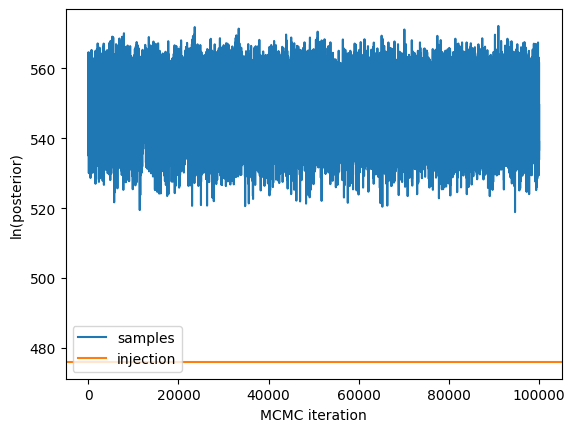

In [29]:
samples.plt_posterior_vals(legend=True)

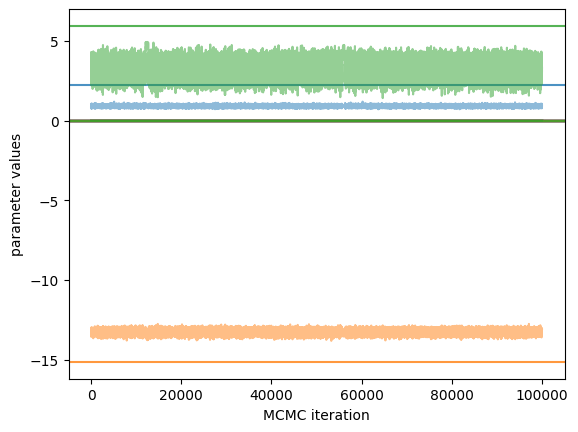

In [30]:
samples.trace_plt()

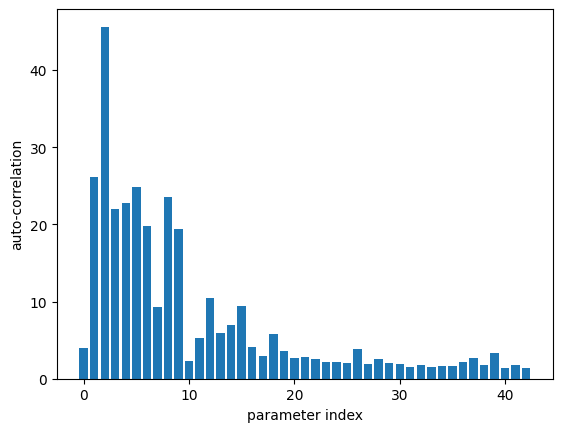

In [31]:
samples.plt_auto_corr()

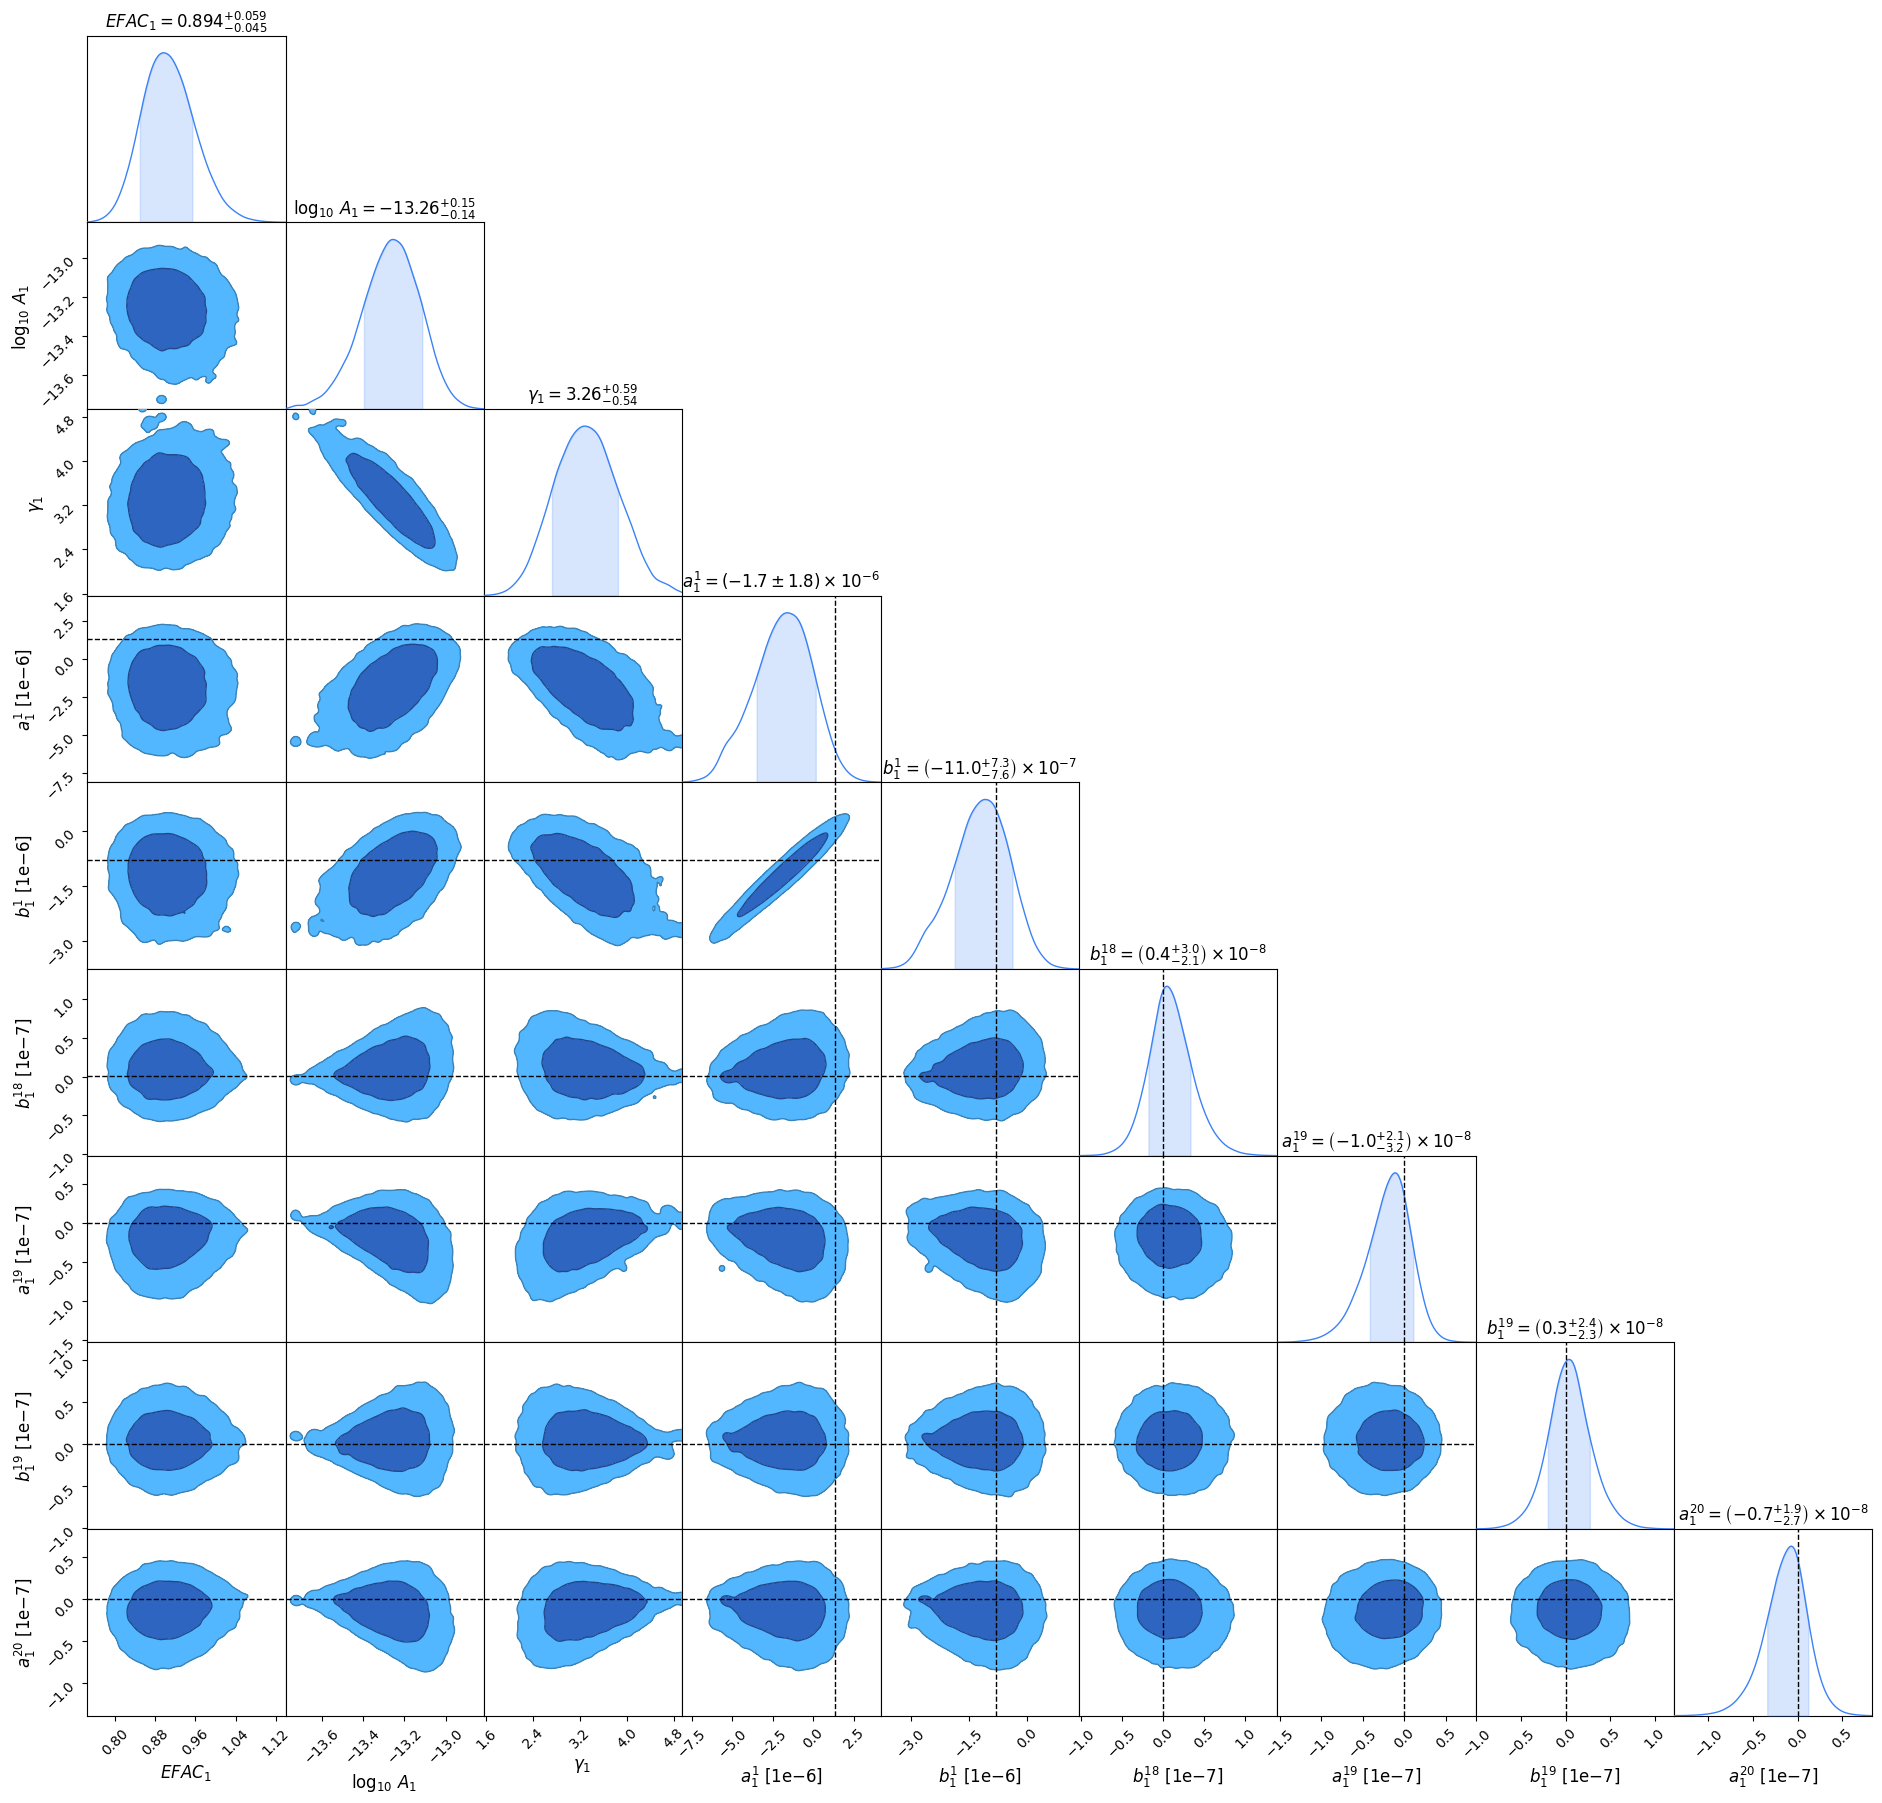

In [32]:
# indices of parameters to use in corner plot
samples.corner_plt(param_ndxs=np.concatenate((np.r_[:5], np.r_[-5:-1])))

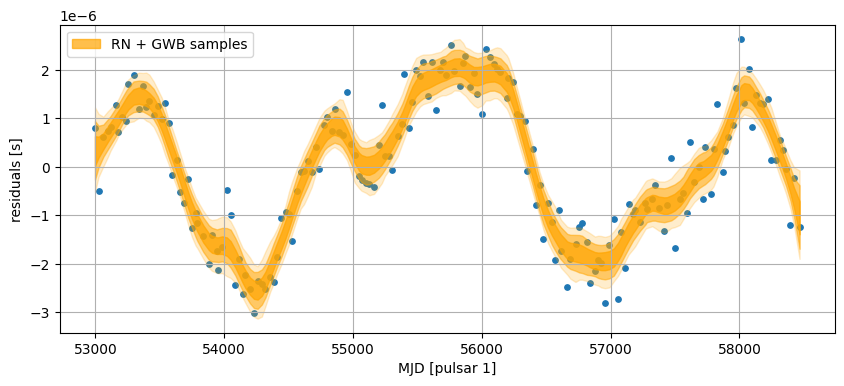

In [ ]:
# Bayesogram
psr_ndx = 0
fair_draw_ndxs = np.random.choice(samples_arr.shape[0], (1000,))

# percentile layers for plotting densities of samples
percentile_layers = [0.15, 2.5, 16.]
alphas = [0.2, 0.5, 0.7]

# plot data, samples, and injected signals
plt.figure(figsize=(10, 4))
plt.scatter(data_dict['toas'][psr_ndx] / 86400., data_dict['residuals'][psr_ndx], s=15)
plt.xlabel('TOAs (MJD)')
plt.ylabel('timing residuals (s)')

rn_gwb_signals = np.array([Rs[psr_ndx] @ data_dict['Fs'][psr_ndx] @ samples_arr[ndx, pta_for_parameters.a_ndxs].reshape((pta_for_parameters.Np, pta_for_parameters.Na))[psr_ndx]
                            for ndx in fair_draw_ndxs])
for percentile, alpha in zip(percentile_layers, alphas):
    if percentile != percentile_layers[-1]:
        plt.fill_between(data_dict['toas'][psr_ndx] / 86400., np.percentile(rn_gwb_signals, percentile, axis=0),
                        np.percentile(rn_gwb_signals, 100. - percentile, axis=0),
                        color='orange', alpha=alpha)
    else:
        plt.fill_between(data_dict['toas'][psr_ndx] / 86400., np.percentile(rn_gwb_signals, percentile, axis=0),
                        np.percentile(rn_gwb_signals, 100. - percentile, axis=0),
                        color='orange', alpha=alpha, label='RN + GWB samples')

plt.xlabel(f'MJD [pulsar {psr_ndx + 1}]')
plt.ylabel('residuals [s]')
plt.legend()
plt.grid()
plt.show()